In [2]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten

# modules for plotting in this notebook
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
tf.__version__


'2.3.0'

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 60,000 training data and 10,000 test data of 28x28 pixel images
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (60000, 28, 28)
y_train shape (60000,)
x_test shape (10000, 28, 28)
y_test shape (10000,)


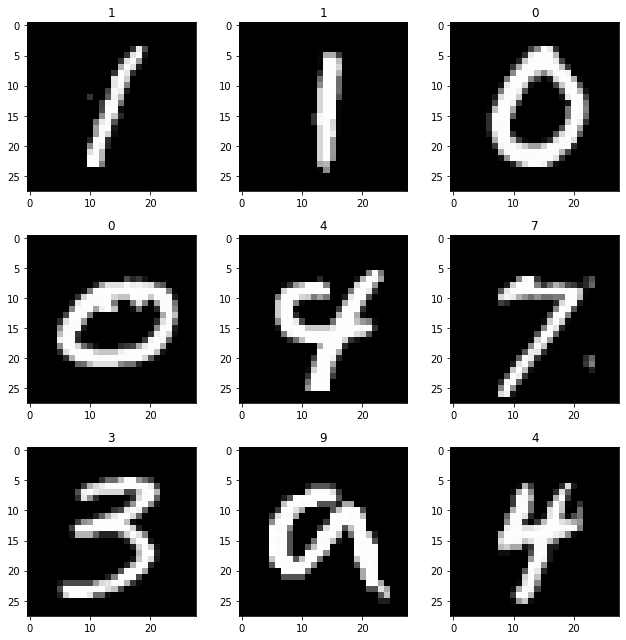

In [5]:
fig = plt.figure(figsize=(9,9))

for i in range(9):
  plt.subplot(3,3,i+1)
  num = random.randint(0, len(x_train))
  plt.imshow(x_train[num], cmap="gray", interpolation=None)
  plt.title(y_train[num])

plt.tight_layout()

In [9]:
# Create a model with a 28x28 pixel input vector
#    -> 1 hidden layer of 64 nodes
#    -> 10 categories of outputs (digits 0-9)
def create_model():
  model = Sequential()
  model.add(Flatten(input_shape=(28*28,)))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(10, activation="softmax"))
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [11]:
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)

x_train shape (60000, 784)
y_train shape (60000, 10)


In [12]:
model.fit(x=x_train, y=y_train, batch_size=128, epochs=5, verbose=1)

scores = model.evaluate(x_test, y_test, verbose=2)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

model.save("mnist.h5")

Epoch 1/5
469/469 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8867
Epoch 2/5
469/469 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.9416
Epoch 3/5
469/469 [==============================] - 0s 1ms/step - loss: 0.1543 - accuracy: 0.9561
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1246 - accuracy: 0.9640
Epoch 5/5
469/469 [==============================] - 1s 1ms/step - loss: 0.1052 - accuracy: 0.9698
313/313 - 0s - loss: 0.1100 - accuracy: 0.9683
Test Loss: 0.11004432290792465
Test Accuracy: 0.9682999849319458


In [13]:
mnist_sampleset = tf.data.Dataset.from_tensor_slices((x_test)).batch(1)
def representative_dataset_gen():
    for input_value in mnist_sampleset.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpa6jf0xmt/assets


205140

In [14]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Adjust the model interpreter to take 10,000 inputs at once instead of just 1
interpreter.resize_tensor_input(input_details[0]["index"], (10000, 28*28))
interpreter.resize_tensor_input(output_details[0]["index"], (10000, 10))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set the test input and run
interpreter.set_tensor(input_details[0]["index"], x_test)
interpreter.invoke()

# Get the result and check its accuracy
output_data = interpreter.get_tensor(output_details[0]["index"])

a = [np.argmax(y, axis=None, out=None) for y in output_data]
b = [np.argmax(y, axis=None, out=None) for y in y_test]

accuracy = (np.array(a) == np.array(b)).mean()
print("TFLite Accuracy:", accuracy)

TFLite Accuracy: 0.9683


In [15]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "const unsigned char tf_model[] = {\n  " + ascii_bytes + "\n};\nunsigned int tf_model_len = " + str(len(tflite_binary)) + ";"
# print(c_file)
open("model.h", "w").write(c_file)

1271940